In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow.contrib.slim as slim
import os

In [2]:
mb_size = 32
batch_size = 32
X_dim = [28,28,1]
z_dim = 100
h_dim = 128
lr = 1e-3
d_steps = 3
n_class = 10
nz = 100 # z dim

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


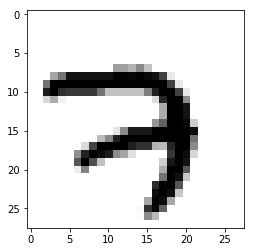

In [3]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
x_train = mnist.train.images[:50,:]
x_train = x_train.reshape([50,28,28,1])
#randomNum = random.randint(0,25)
image = x_train[0]
plt.imshow(image[:,:,0], cmap=plt.get_cmap('gray_r'))
plt.show()

In [4]:
def plot(samples):
    fig = plt.figure(figsize=(4, 8))
    gs = gridspec.GridSpec(4, 8)
    gs.update(wspace=0.05, hspace=0.05)
    #print len(samples)
    for i, sample in enumerate(samples):
        #print i
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [6]:
def log(x):
    return tf.log(x + 1e-8)
    

In [7]:
X = tf.placeholder(
            name='image', dtype=tf.float32,
            shape=[batch_size, 28, 28, 1],
        )
z = tf.placeholder(tf.float32, shape=[None, nz])
y = tf.placeholder(
            name='label', dtype=tf.float32, shape=[batch_size, n_class],
        )

D_W1 = tf.Variable(xavier_init([28, 28, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, n_class]))
D_b2 = tf.Variable(tf.zeros(shape=[n_class]))

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W2 = tf.Variable(xavier_init([h_dim, 28, 28]))
G_b2 = tf.Variable(tf.zeros(shape=[28, 28]))

# theta_G = [G_W1, G_W2, G_b1, G_b2]
# theta_D = [D_W1, D_W2, D_b1, D_b2]

In [8]:
def sample_z(m, n):
    sample = np.random.uniform(-1., 1., size=[m, n])
    sample = sample.astype(np.float32, copy=False)
    #y = x.view('float32')
    #y[:] = x
    return sample

my_sample = sample_z(5,1)
print my_sample.dtype

float32


In [9]:
data_info = np.array([28, 28, 10, 1])

conv_info = np.array([32, 64, 128])

deconv_info = np.array([[100, 2, 1], [25, 3, 2], [6, 4, 2], [1, 6, 2]])

In [10]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions - labels)
    condition = tf.less(residual, delta)
    small_res = 0.5 * tf.square(residual)
    large_res = delta * residual - 0.5 * tf.square(delta)
    return tf.where(condition, small_res, large_res)

def conv2d(input, output_shape, is_train, k_h=5, k_w=5, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input.get_shape()[-1], output_shape],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input, w, strides=[1, 2, 2, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_shape], initializer=tf.constant_initializer(0.0))
        conv = lrelu(tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape()))
        bn = tf.contrib.layers.batch_norm(conv, center=True, scale=True,
                                          decay=0.9, is_training=is_train,
                                          updates_collections=None)
    return bn

def deconv2d(input, deconv_info, is_train, name="deconv2d", stddev=0.02, activation_fn=None):
    with tf.variable_scope(name):
        output_shape = deconv_info[0]
        k = deconv_info[1]
        s = deconv_info[2]
        deconv = layers.conv2d_transpose(
            input, num_outputs=output_shape,
            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
            biases_initializer=tf.zeros_initializer(),
            kernel_size=[k, k], stride=[s, s], padding='VALID'
        )
        if not activation_fn:
            deconv = tf.nn.relu(deconv)
            deconv = tf.contrib.layers.batch_norm(
                deconv, center=True, scale=True,  decay=0.9,
                is_training=is_train, updates_collections=None
            )
        else:
            deconv = activation_fn(deconv)
        return deconv

In [11]:
is_train=True
image_shape = [32, 28, 28, 1]
def G(z, scope='Generator'):
    with tf.variable_scope(scope) as scope:
        #log.warn(scope.name)
        z = tf.reshape(z, [batch_size, 1, 1, -1])
        g_1 = deconv2d(z, deconv_info[0], is_train, name='g_1_deconv')
        #log.info('{} {}'.format(scope.name, g_1))
        g_2 = deconv2d(g_1, deconv_info[1], is_train, name='g_2_deconv')
        #log.info('{} {}'.format(scope.name, g_2))
        g_3 = deconv2d(g_2, deconv_info[2], is_train, name='g_3_deconv')
        #log.info('{} {}'.format(scope.name, g_3))
        g_4 = deconv2d(g_3, deconv_info[3], is_train, name='g_4_deconv', activation_fn=tf.tanh)
        #log.info('{} {}'.format(scope.name, g_4))
        output = g_4
        #print X.get_shape().as_list()
        assert output.get_shape().as_list() == image_shape, output.get_shape().as_list()
        return output

In [12]:
def D(img, scope='Discriminator', reuse=True):
    with tf.variable_scope(scope, reuse=reuse) as scope:
        #if not reuse: log.warn(scope.name)
        d_1 = conv2d(img, conv_info[0], is_train, name='d_1_conv')
        d_1 = slim.dropout(d_1, keep_prob=0.5, is_training=is_train, scope='d_1_conv/')
        #if not reuse: log.info('{} {}'.format(scope.name, d_1))
        d_2 = conv2d(d_1, conv_info[1], is_train, name='d_2_conv')
        d_2 = slim.dropout(d_2, keep_prob=0.5, is_training=is_train, scope='d_2_conv/')
        #if not reuse: log.info('{} {}'.format(scope.name, d_2))
        d_3 = conv2d(d_2, conv_info[2], is_train, name='d_3_conv')
        d_3 = slim.dropout(d_3, keep_prob=0.5, is_training=is_train, scope='d_3_conv/')
        #if not reuse: log.info('{} {}'.format(scope.name, d_3))
        d_4 = slim.fully_connected(
            tf.reshape(d_3, [batch_size, -1]), n_class, scope='d_4_fc', activation_fn=None)
        #if not reuse: log.info('{} {}'.format(scope.name, d_4))
        output = d_4
        assert output.get_shape().as_list() == [batch_size, n_class]
        return tf.nn.softmax(output), output

In [13]:
epsilon = 1.0e-6
LAMBA = 1
# y has dim batch_size x num_classes
# entropy 1
def marginal_entropy(y):
    y_1 = tf.reduce_mean(y, axis=0) #1/N sum y_i
    y_2 = -y_1 * tf.log(y_1+epsilon)
    y_3 = tf.reduce_sum(y_2)
    return y_3

def entropy(y):
    #batch_size= K.int_shape(y)[0]
    y_1 = -y * tf.log(y+epsilon)
    y_2 = tf.reduce_sum(y_1,axis=1)
    y_3 = tf.reduce_mean(y_2,axis=0)
    return y_3

In [14]:
print deconv_info[0]

[100   2   1]


In [15]:
#from util import log
z = tf.random_uniform([batch_size, nz], minval=-1, maxval=1, dtype=tf.float32)
G_sample = G(z)

D_real, D_real_logits = D(X, scope='Discriminator', reuse=False)
D_fake, D_fake_logits = D(G_sample, scope='Discriminator', reuse=True)

D_target = 1./mb_size
G_target = 1./(mb_size*2)

#Z = tf.reduce_sum(tf.exp(-D_real)) + tf.reduce_sum(tf.exp(-D_fake))

#D_loss = tf.reduce_sum(D_target * D_real) + log(Z)
#G_loss = tf.reduce_sum(G_target * D_real) + tf.reduce_sum(G_target * D_fake) + log(Z)

D_loss = -marginal_entropy(D_real) + entropy(D_real) - entropy(D_fake) + tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=D_real_logits)
G_loss = -marginal_entropy(D_fake) + entropy(D_fake)

all_vars = tf.trainable_variables()

theta_D = [v for v in all_vars if v.name.startswith('Discriminator')]
#log.warn("********* d_var ********** "); slim.model_analyzer.analyze_vars(d_var, print_info=True)

theta_G = [v for v in all_vars if v.name.startswith(('Generator'))]
#log.warn("********* g_var ********** "); slim.model_analyzer.analyze_vars(g_var, print_info=True)

D_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=theta_G))

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

dir_name ='out_3/'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

i = 0

In [17]:
#100,000 is good
#print every 1000
for it in range(100):
    X_mb, y_mb = mnist.train.next_batch(mb_size)
    X_mb = X_mb.reshape([mb_size, 28, 28, 1])
    #z_mb = sample_z(mb_size, z_dim)

    _, D_loss_curr = sess.run(
        [D_solver, D_loss], feed_dict={X: X_mb, y: y_mb}
    )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss], feed_dict={X: X_mb, y: y_mb}
    )

    if it % 10 == 0:
        print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        
        #z_mb = sample_z(16, z_dim)
        samples = sess.run(G_sample)

        fig = plot(samples)
        plt.savefig(dir_name+'{}.png'
                    .format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0; D_loss: [ 3.; G_loss: -0.9044
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 10; D_loss: [-2.; G_loss: -0.9815
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 20; D_loss: [-2.; G_loss: -1.061
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 30; D_loss: [-2.; G_loss: -1.269
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 40; D_loss: [ 1.; G_loss: -1.361
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 50; D_loss: [ -2; G_loss: -1.373
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 60; D_loss: [-2.; G_loss: -1.326
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Iter: 70; D_loss: [-2.; G_loss: -1.484
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23